In [1]:
import tnn
import torch
import torch.nn as nn
import torch.utils.data as data
import numpy as np

from datasets import load_dataset

device = "cuda"

In [2]:
dataset = load_dataset("ylecun/mnist", num_proc=2)
train_size = 10000
test_size = 1000

train = dataset.get("train")
test = dataset.get("test")

train_indices = np.random.choice(len(train), size=train_size, replace=False)
test_indices = np.random.choice(len(test), size=test_size, replace=False)

train = train.select(train_indices)
test = test.select(test_indices)

In [3]:
def to_numpy(example):
    arr = np.reshape(example["image"], -1) / 255.0
    example["input"] = arr
    return example


train_dataset = train.map(to_numpy, num_proc=2).select_columns(["input", "label"])
test_dataset = test.map(to_numpy, num_proc=2).select_columns(["input", "label"])

Map (num_proc=2):   0%|          | 0/10000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [4]:
def collate_fn(batch):
    inputs = torch.tensor([ex["input"] for ex in batch]).float()
    labels = torch.tensor([ex["label"] for ex in batch]).long()
    return inputs, labels


trainloader = data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=2,
)
testloader = data.DataLoader(
    test_dataset,
    batch_size=len(test_dataset),
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=2,
)

In [5]:
model = tnn.Model(tnn.MLP())
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)

In [6]:
trainer = tnn.Trainer(
    model=model,
    optim=optim,
    loss_fn=loss_fn,
    dataloader=trainloader,
    eval_dataloader=testloader,
    epochs=50,
    save_weights=True,
    device=device,
    path="../training/mnist-test.h5",
    verbose=25,
)

In [ ]:
metrics = trainer.train()

In [7]:
landscape = tnn.Landscape.from_file(
    trainer_path="../training/mnist-test.h5",
    model=model,
    loss_fn=loss_fn,
    eval_dataloader=testloader,
    device=device,
    verbose=10
)

In [14]:
landscape_dict = landscape.create_meshgrid(
    mode="pca",
    resolution=10,
    endpoints=(-100, 100),
    pca_matrix_indices=range(10)
)

meshgrid creation using pca
model using cuda
meshgrid creation started
(iter: 10): iter loss: 0.1558
(iter: 20): iter loss: 0.1579
(iter: 30): iter loss: 0.1611
(iter: 40): iter loss: 0.1653
(iter: 50): iter loss: 0.1705
(iter: 60): iter loss: 0.1771
(iter: 70): iter loss: 0.1857
(iter: 80): iter loss: 0.1964
(iter: 90): iter loss: 0.2094
(iter: 100): iter loss: 0.2253
meshgrid creation complete


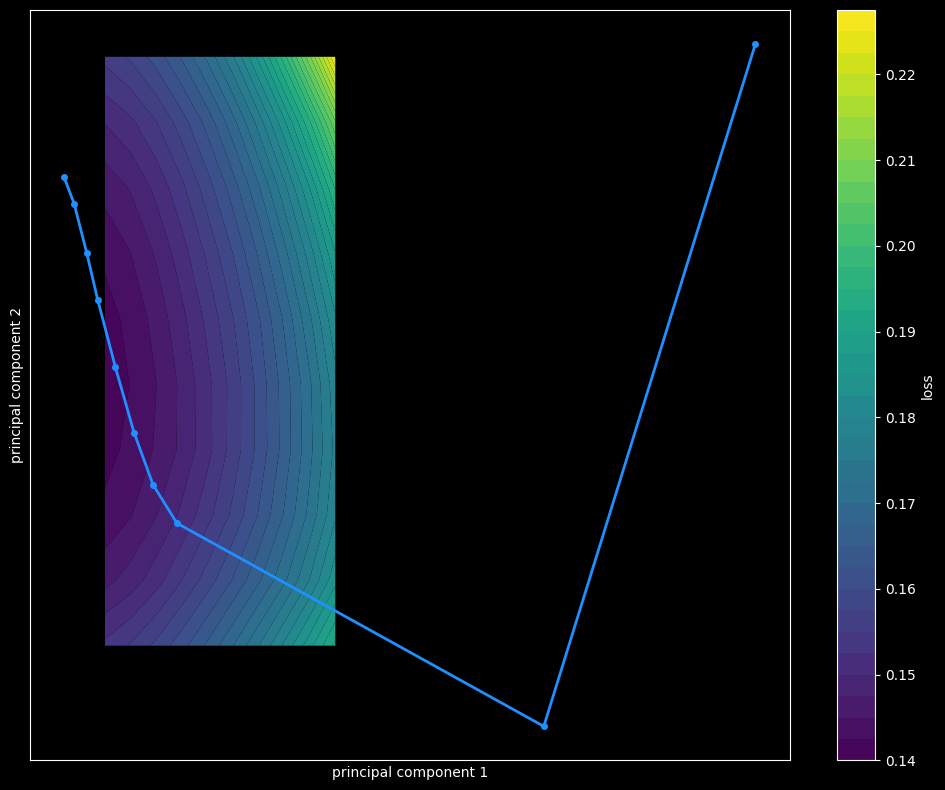

In [15]:
meshgrid = landscape_dict.get("meshgrid")
optim_path = landscape_dict.get("optim_path")
tnn.plot_contour(meshgrid, optim_path, levels=40)

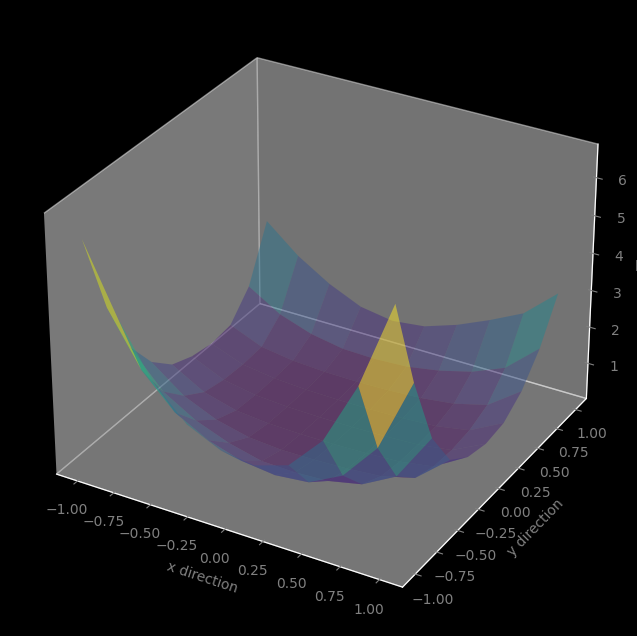

In [10]:
tnn.plot_surface_3D(meshgrid)